In [1]:
import scipy
from scipy.stats import median_abs_deviation as mad
import numpy as np
from matplotlib import pyplot as plt
import time
from  scipy.io import loadmat as loadmat

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing'

In [4]:
rootfolder = '/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing/Assignments'

Useful function for the plot

In [5]:
def display_band( X, par,epsi=0.001,col='k'):
    x1 = np.min(X[0, :])
    x2 = np.max(X[0, :])
    y1 = np.min(X[1, :])
    y2 = np.max(X[1, :])

    # extend the line for the k# of its lenght
    k = 0.01
    dx = x2-x1
    dy = y2-y1
    l = np.sqrt(dx**2+dy**2)
    x1 = x1 - k*l
    x2 = x2 + k*l
    y1 = y1 - k*l
    y2 = y2 + k*l
    ##
    if np.abs(par[1])<2e-2 :
        #disp('vertical line')
        a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
        b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
    else:
        a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
        b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

    if np.abs(par[0])<1e-5:
        v = np.array([0,1])
    else:
        v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

    v = v / np.sqrt(np.sum(v**2))
    # corners of the bands
    v = v[:, np.newaxis]
    a1 = a - epsi * v
    a2 = a + epsi * v
    b1 = b - epsi * v
    b2 = b + epsi * v

    px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
    py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
    plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
    plt.gca().set_aspect('equal')

def display_clust(X, G, cmap):
    G = np.asarray(G, dtype=int)
    switch_out = 1
    smb = 'o'
    col = []
    num_clust = int(np.max(G))

    for i in range(1, num_clust+1):
        id = G == i
        id = id.squeeze()
        x = X[0, id]
        y = X[1, id]
        if len(col) == 0:
            plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
        else:
            plt.scatter(x,y,50,col,marker=smb,edgecolors=col, alpha=0.1)
        if switch_out == 1:
            id = G == 0
            id = id.squeeze()
            plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)

Function that computes the residual between points and a line

In [6]:
def res_line(X, M):
  if len(M.shape) > 1:
    num_lines = M.shape[1]
  else:
    num_lines = 1

  if num_lines == 1:
    d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
  else:
    n = X.shape[1]
    d = np.zeros((n, num_lines))
    for i in range(num_lines):
      d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])
  return d

Functions to add outlier to the dataset

In [19]:
def addOutliersInBB(X, nOutliers, k=0.1):
    xmin = np.min(X[0, :])
    xmax = np.max(X[0, :])
    ymin = np.min(X[1, :])
    ymax = np.max(X[1, :])
    wx = xmax-xmin
    wy = ymax -ymin
    dx = k*wx
    dy = k*wy

    Y = np.hstack((X,np.vstack(((xmax-xmin+2*dx) * np.random.uniform(size=(1, nOutliers)) + xmin-dx,
                             (ymax-ymin+2*dy) * np.random.uniform(size=(1, nOutliers)) + ymin-dy))
                ))
    return Y

Ransac
------
Use the implementation from the last lecture

Useful function for computing the Design Matrix

In [8]:
def compute_design_matrix(P, method='ols'):
  P = np.array(P)
  # extract x and y coordinates
  x = P[0, :]
  y = P[1, :]
  # construct the design matrix
  if method == 'ols':
    A = np.vstack((x, y, np.ones_like(x)))
  else:
    # create a matrix [x, y, 1]
    A = np.vstack((x, y, np.ones_like(x)))
  return A

In [9]:
def fit_line_dlt(P):
  # preconditioning phase: bring our points arounf the origin.
  # The effects of this phase needs to be reversed at the end
  mx = np.mean(P[0, :])
  my = np.mean(P[1, :])
  stdx = np.std(P[0, :])
  stdy = np.std(P[1, :])
  # normalization
  x_norm = (P[0, :] - mx) / stdx
  y_norm = (P[1, :] - my) / stdy
  ones = np.ones_like(x_norm)

  # design matrix
  A= np.vstack((x_norm, y_norm, ones)).T
  # vector of responses
  y = P.T[:, 1]

  # SVD
  U, D, V = np.linalg.svd(A)

  theta = V[-1, :]

  # invert the preconditioning phase
  a, b, c = theta[0], theta[1], theta[2]
  a_0 = a / stdx
  b_0 = b / stdy
  c_0 = c - a * mx / stdx - b * my / stdy
  # normalization
  norm = np.sqrt(a_0 ** 2 + b_0 ** 2)
  a_0 = a_0 / norm
  b_0 = b_0 / norm
  c_0 = c_0 / norm
  theta = np.array([a_0, b_0, c_0])

  residuals = A @ theta
  residual_error = np.sum(residuals ** 2)

  return theta, residuals, residual_error

In [10]:
def simpleRANSAC(X, eps, cardmss = 2):
  """
  SIMPLERANSAC - Robust fit with the LMEDS algorithm
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1]
  # Desired probability of success
  alpha = 0.99

  # Pessimistic estimate of inliers fraction
  f = 0.5

  # set maximum number of iterations
  MaxIterations = int(np.ceil(np.log(1-alpha)/np.log(1 - (1 - f)**cardmss)))

  # set maximum consensus reached
  maxscore = - np.inf

  # initialize bestinliers set
  bestinliers = []

  # initialize bestmodel
  bestmodel = []

  for i in range(MaxIterations):

    # Generate cardmss random indices in the range 0..n-1
    mss = np.random.choice(n, cardmss, replace=False)

    # Fit model to this minimal sample set.
    theta, _, _ = fit_line_dlt(X[:, mss])

    # Evaluate distances between points and model
    sqres = res_line(X, theta)

    # identify inliers: consensus set
    inliers = np.where(sqres < eps)[0]

    # assess consensus (the number of inliers)
    score = len(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta

  return bestmodel, bestinliers

Sequential Ransac
-----------------
Prepare the dataset and set the parameters


In [20]:
epsi = 0.02 # inlier threshold for ransac

temp = loadmat(f'{rootfolder}/data/star5.mat')
#temp = loadmat(f'{rootfolder}/data/stair4.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 2          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 20

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers
G_w_outliers = np.vstack((G, np.zeros((nOut, 1))))


/tmp/ipython-input-2832099321.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
/tmp/ipython-input-2832099321.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


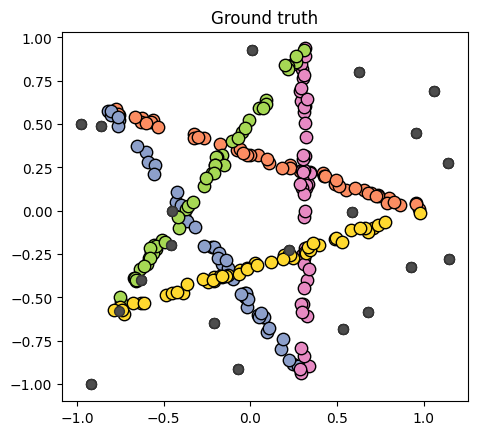

In [21]:
plt.figure(1)
display_clust(X,G_w_outliers, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

Implement the sequential ransac algorithm

In [22]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    current_best_model, current_best_inliers = simpleRANSAC(Y, epsi)
    currentModel.append(current_best_model)
    currentInliers.append(current_best_inliers)

    # remove current inliers
    Y = np.delete(Y, current_best_inliers, axis=1)
    # ((TODO): additional stopping criteria based on the consensus of the last model
    if len(current_best_inliers) < E_min:
        break

    # update iterations
    cnt = cnt + 1

# TODO: implement another stopping criteria based on the consensus of the last model found
# Done above


Show the iteration of Sequential Ransac

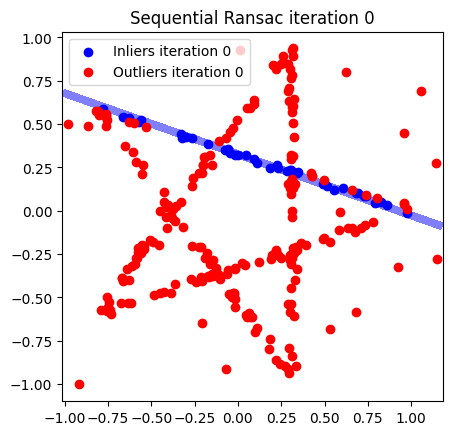

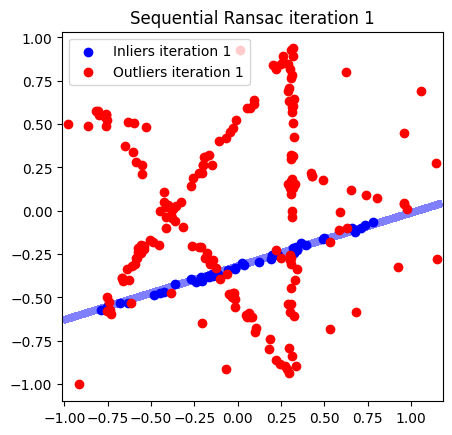

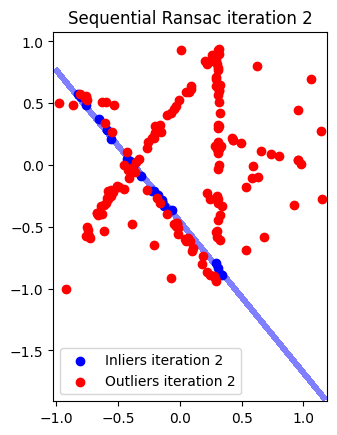

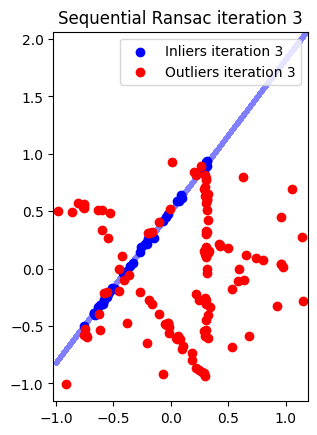

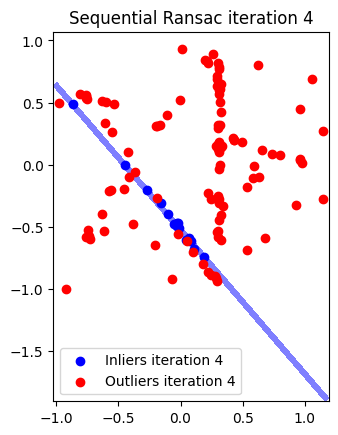

In [23]:
Y = X.copy()
plt.gca().set_aspect('equal')
for i in range(kappa):

    # display a band for each model estimated (see display_band function)
    display_band(Y, currentModel[i], epsi, col)

    # plot inliers for this model
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], color='blue', marker='o', label=f'Inliers iteration {i}')

    # plot outliers
    outliers = np.setdiff1d(np.arange(Y.shape[1]), currentInliers[i])
    plt.scatter(Y[0, outliers], Y[1, outliers], color='red', marker='o', label=f'Outliers iteration {i}')


    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)


    plt.title(f'Sequential Ransac iteration {i:d}')
    plt.legend()
    plt.show()

## TODO (DONE): Try different amount of outliers on both star and stair datasets


In [38]:
def sequential_ransac_experiment(mat_file, nOut, epsi=0.02, kappa=5, E_min=10,col='b' ):
  # load dataset
  temp = loadmat(mat_file)
  X = temp['X'] # data
  G = temp['G'] # ground truth or label (1: normal, 0: outlier

  # colormap
  cmap = loadmat(f'{rootfolder}/data/cmap.mat')['cmap']

  # add outliers
  X = addOutliersInBB(X,nOut)

  # update the label, considering that X previous command has appended nOut otliers
  G_w_outliers = np.vstack((G, np.zeros((nOut, 1))))

  # display GT
  plt.figure()
  display_clust(X,G_w_outliers, cmap)
  plt.title(f'Ground truth (nOut={nOut})')
  plt.gca().set_aspect('equal')
  plt.show()

  # sequential RANSAC
  Y = X.copy()
  currentModel, currentInliers = [], []
  cnt = 0

  while cnt < kappa:
    # run RANSAC
    model, inliers = simpleRANSAC(Y, epsi)
    currentModel.append(model)
    currentInliers.append(inliers)

    # remove inliers
    Y = np.delete(Y, inliers, axis=1)

    # stopping criteria
    if len(inliers) < E_min:
        break

    # update iterations
    cnt = cnt + 1

  # visualization of each iteration
  Y = X.copy()
  for i in range(len(currentModel)):
    plt.figure()
    plt.gca().set_aspect('equal')
    display_band(Y, currentModel[i], epsi, col)
    # inliers
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]],
                    color='blue', marker='o', label=f'Inliers iter {i}')

    # outliers
    outliers = np.setdiff1d(np.arange(Y.shape[1]), currentInliers[i])
    plt.scatter(Y[0, outliers], Y[1, outliers],
                    color='red', marker='o', label=f'Outliers iter {i}')

    plt.title(f'Sequential RANSAC iteration {i} (nOut={nOut})')
    plt.legend()
    plt.show()

    # remove plotted inliers to keep indices aligned
    Y = np.delete(Y, currentInliers[i], axis=1)


/tmp/ipython-input-2832099321.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
/tmp/ipython-input-2832099321.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


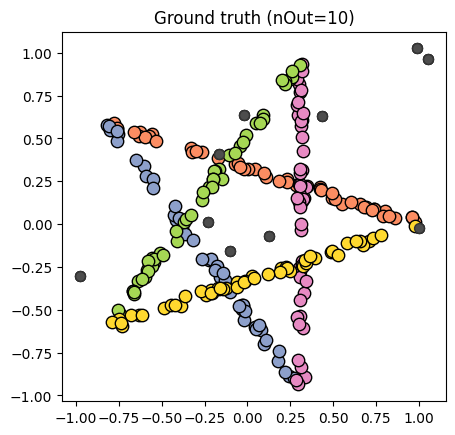

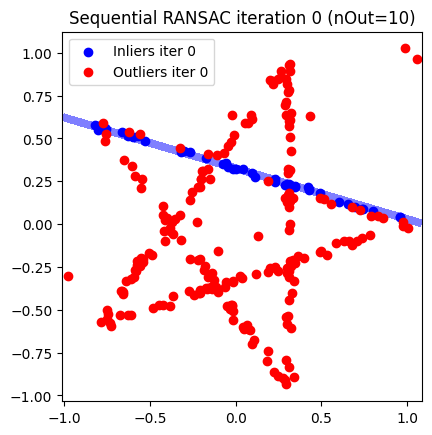

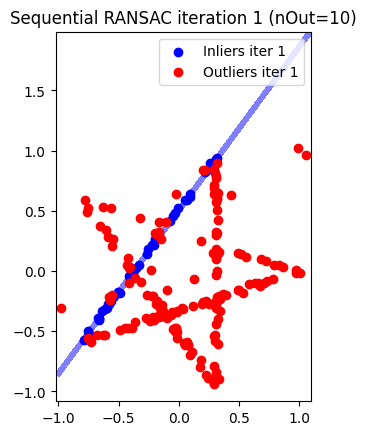

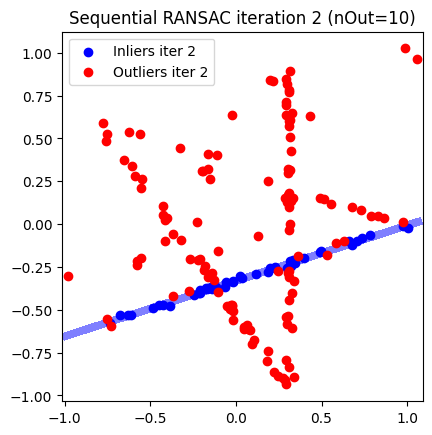

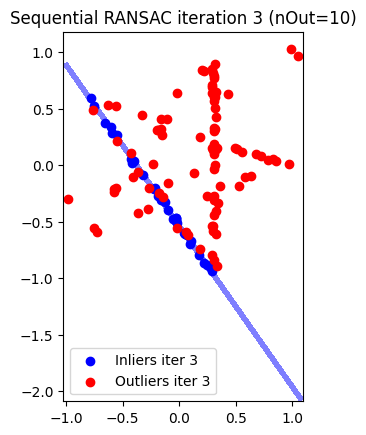

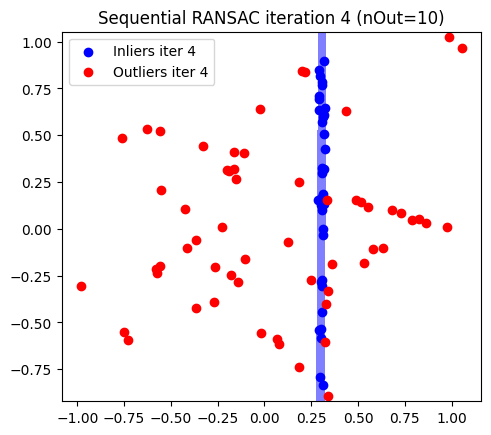

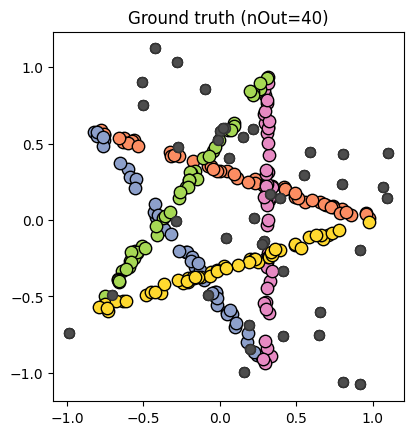

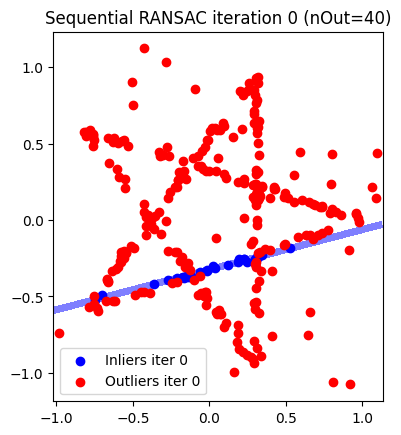

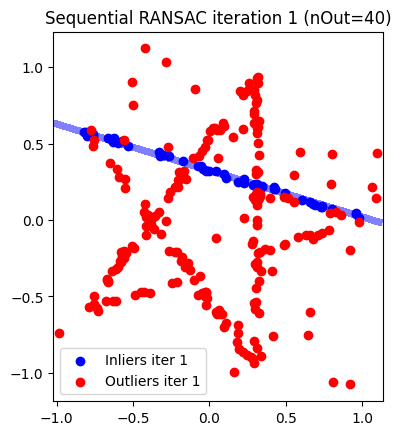

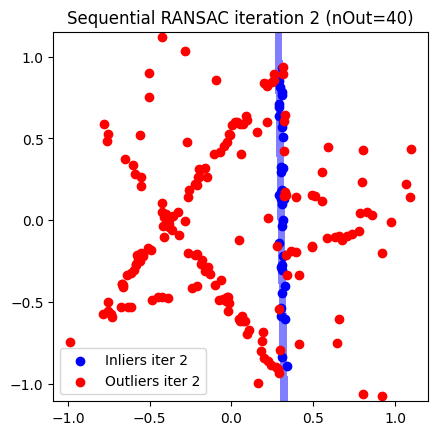

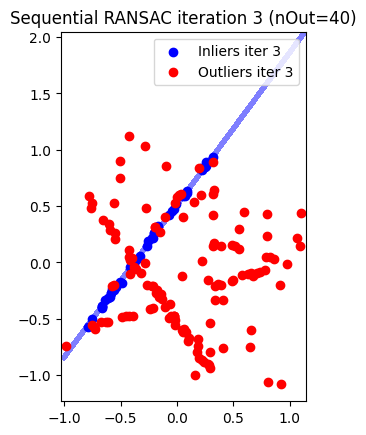

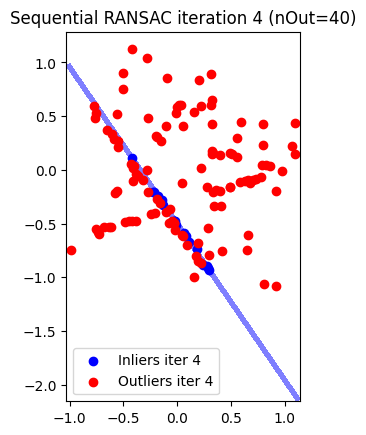

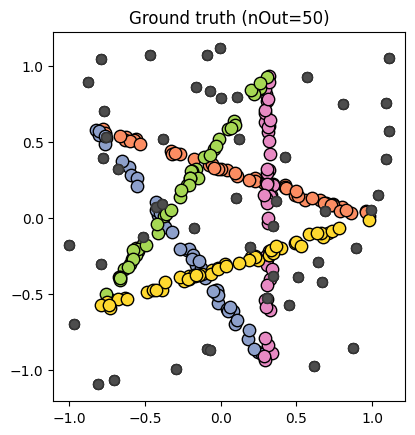

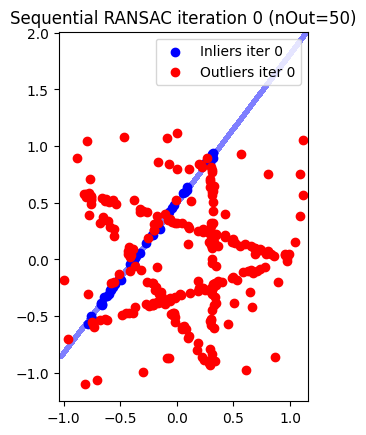

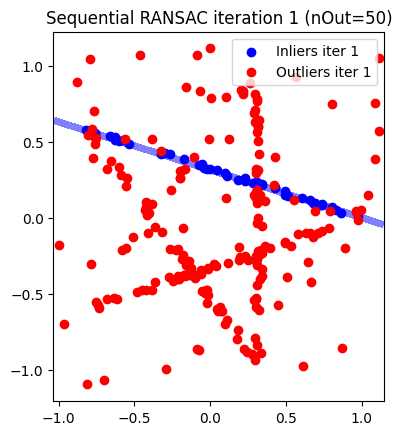

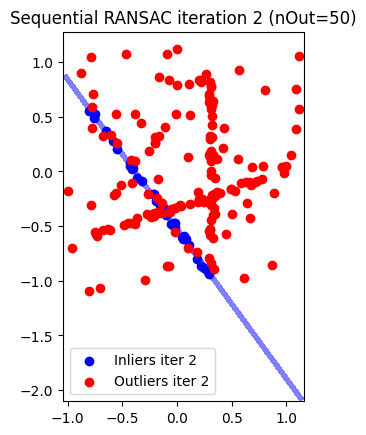

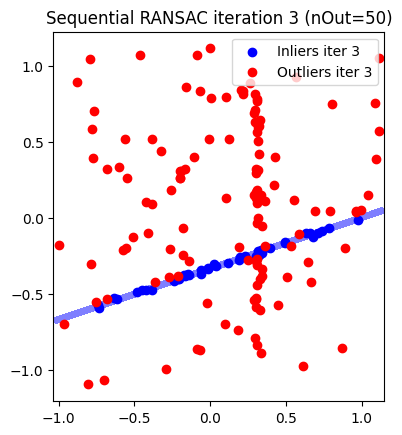

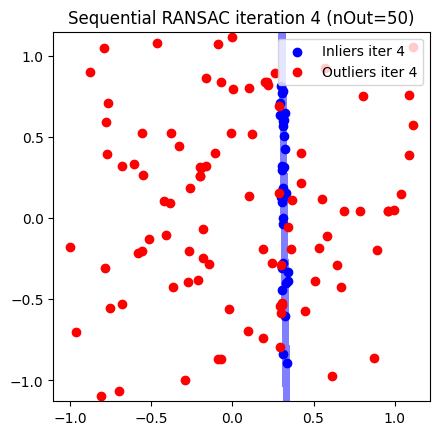

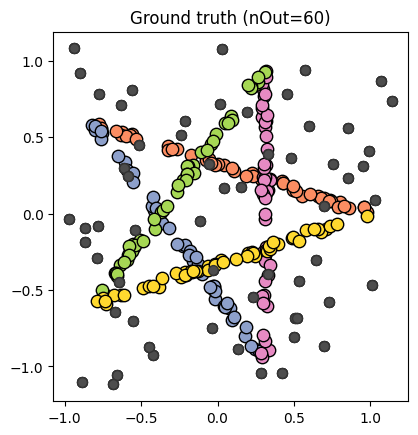

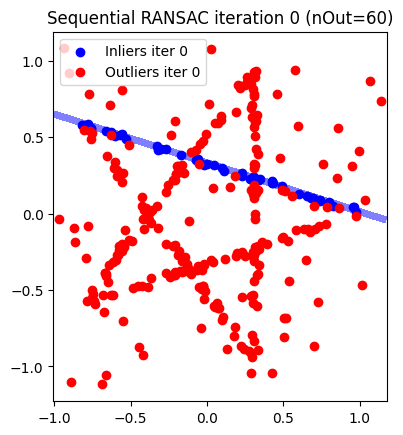

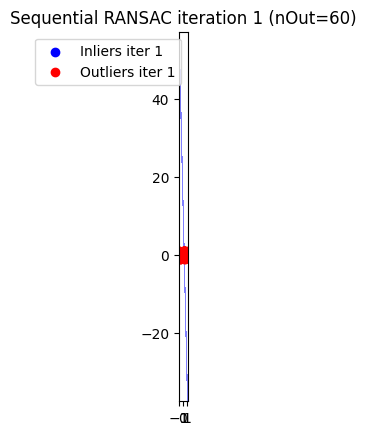

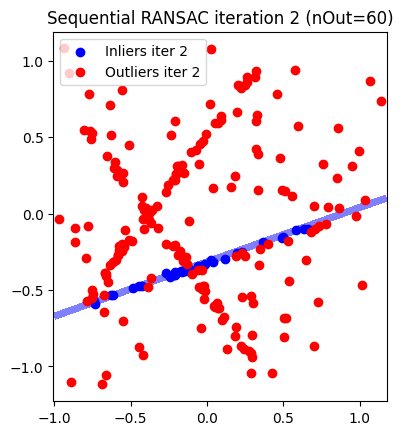

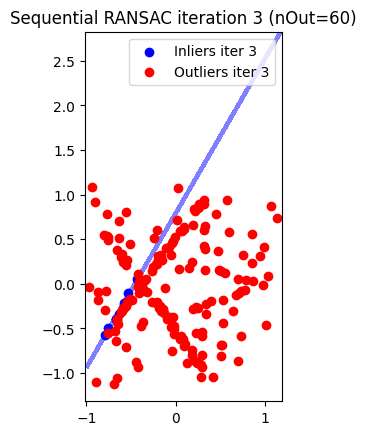

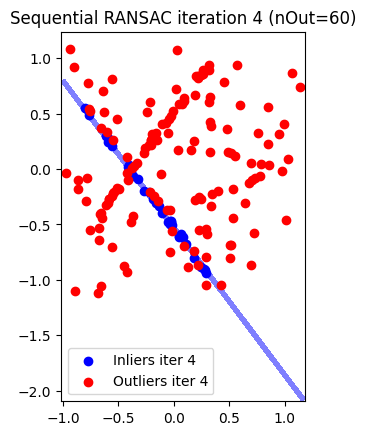

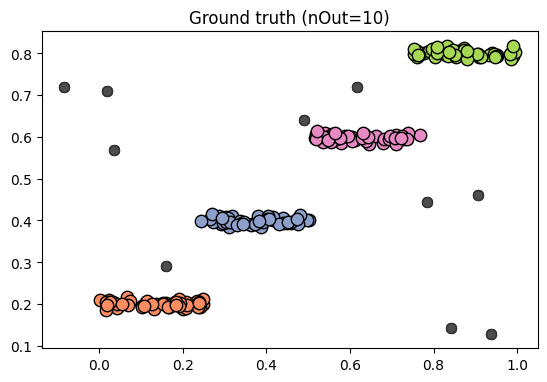

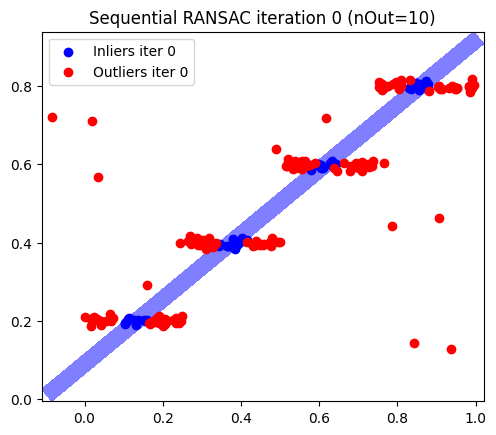

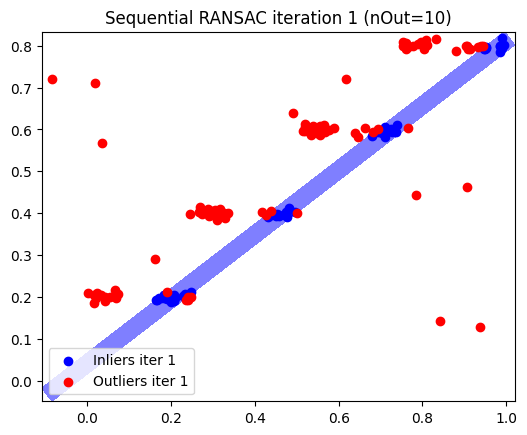

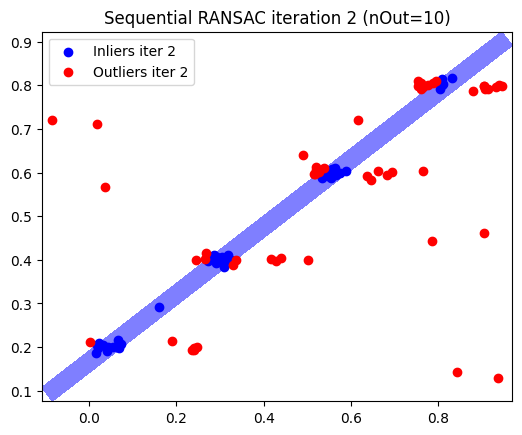

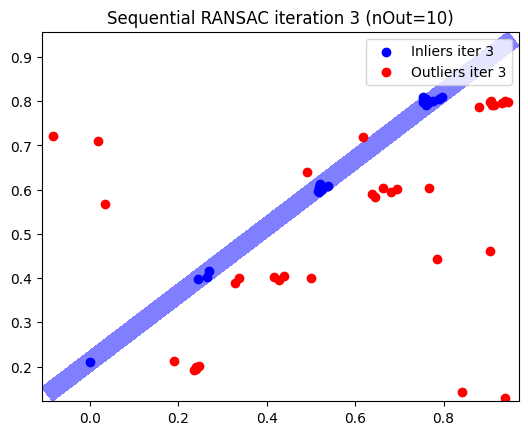

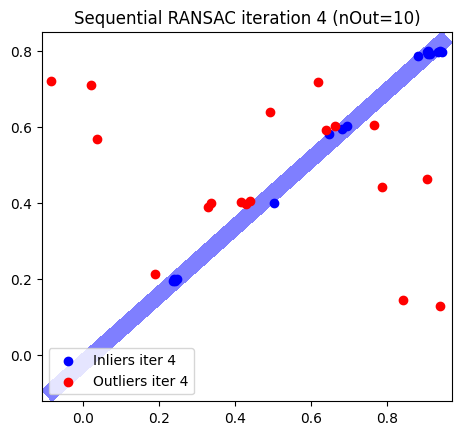

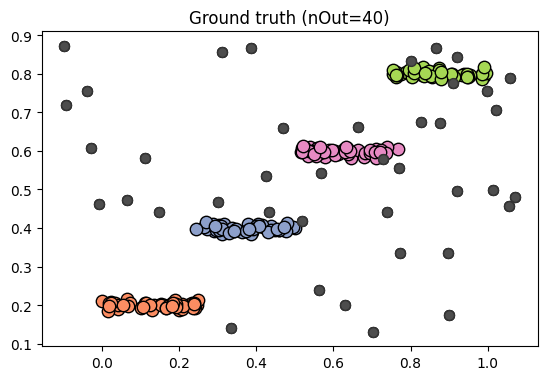

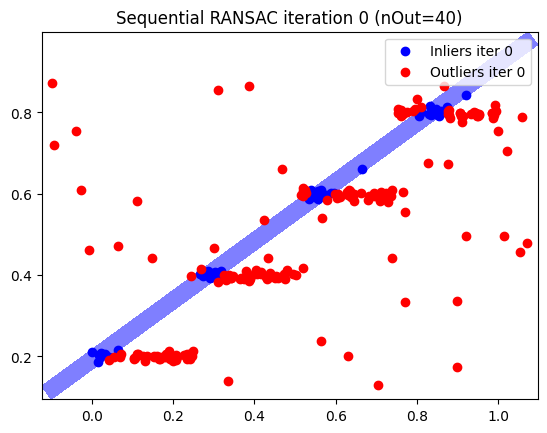

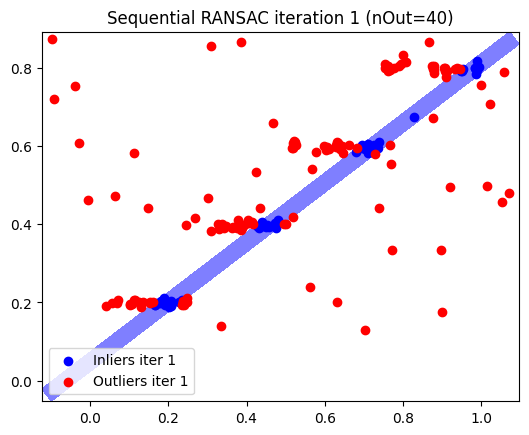

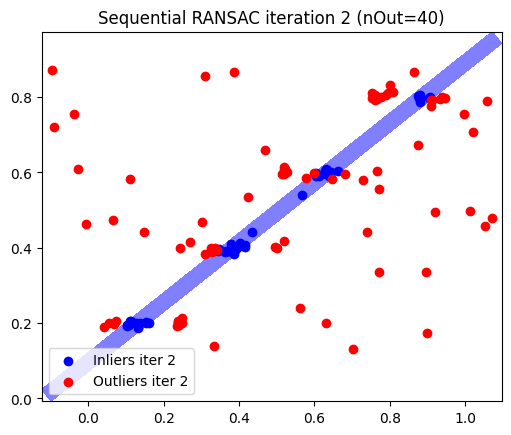

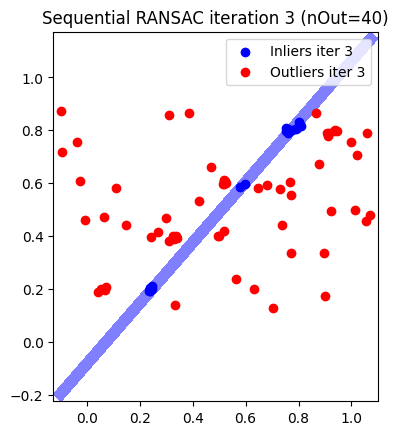

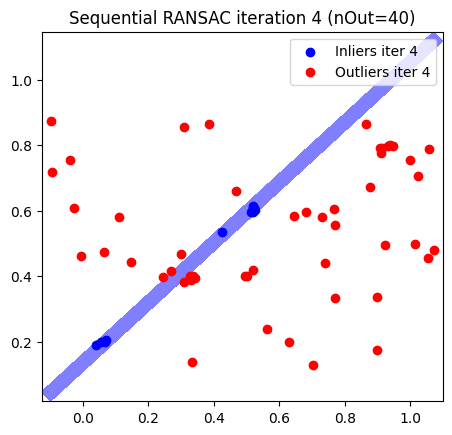

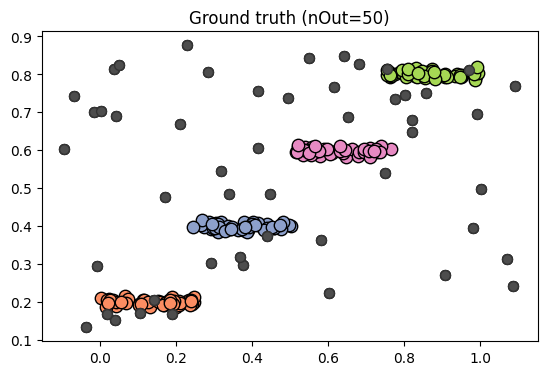

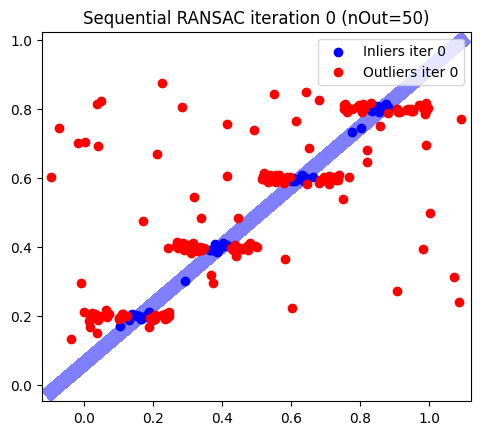

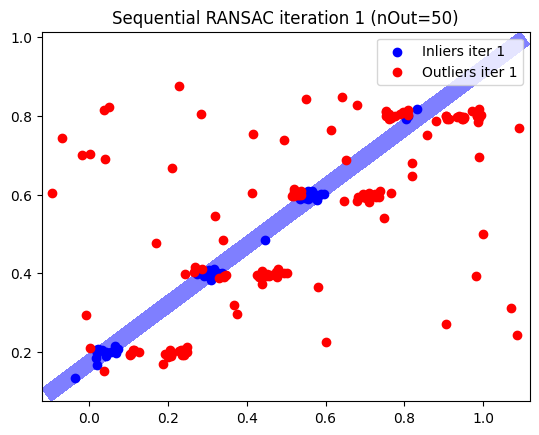

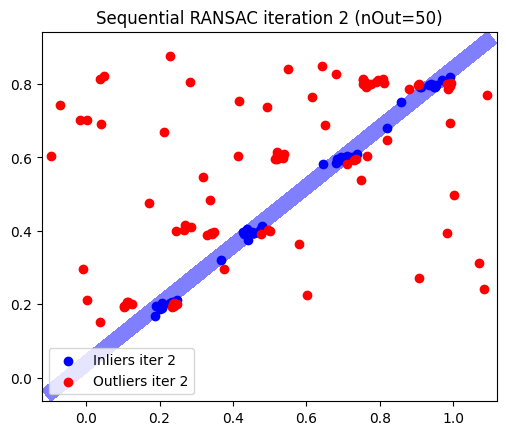

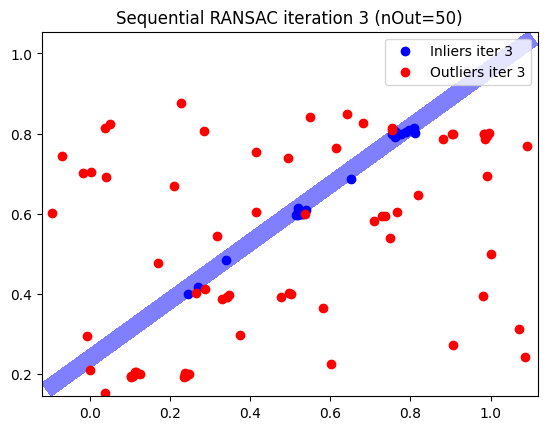

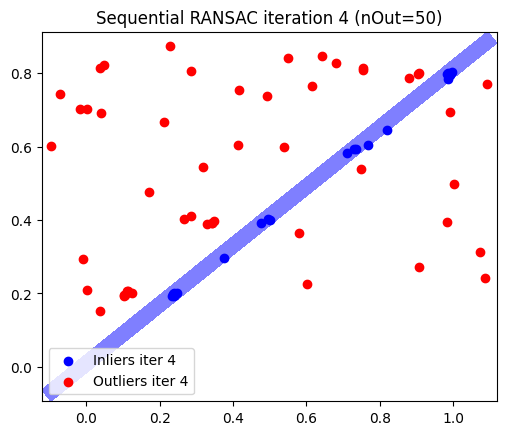

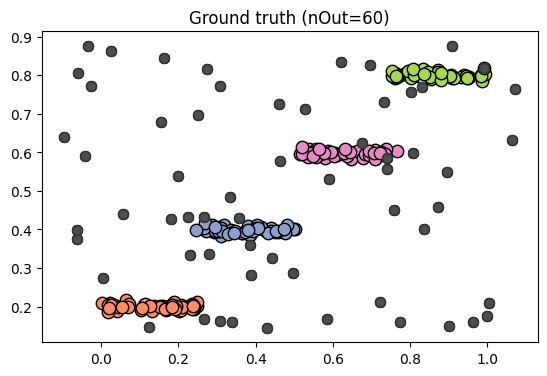

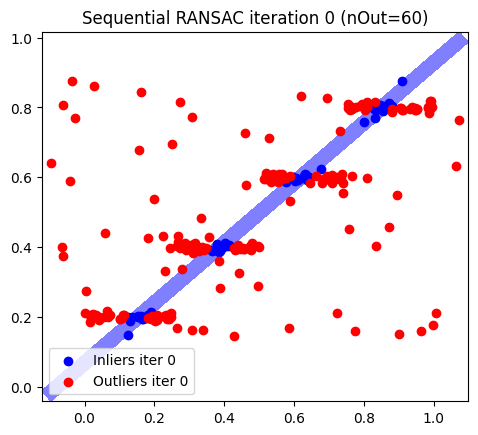

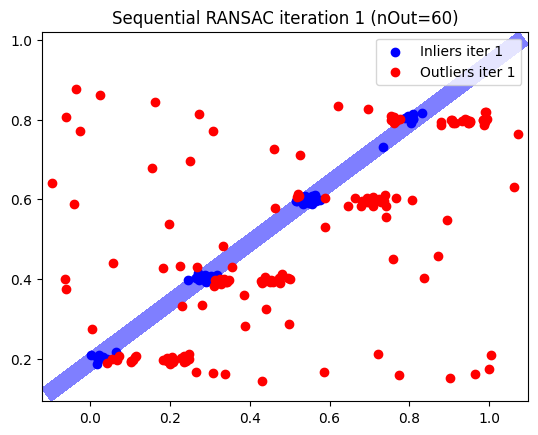

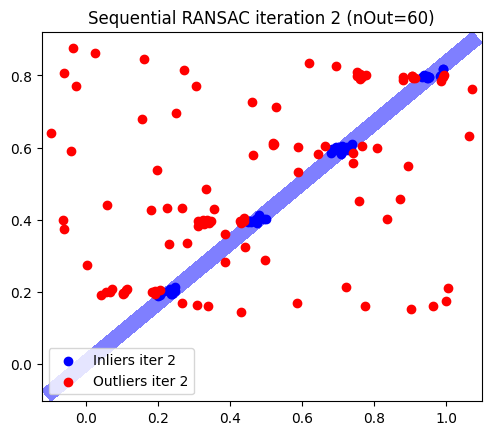

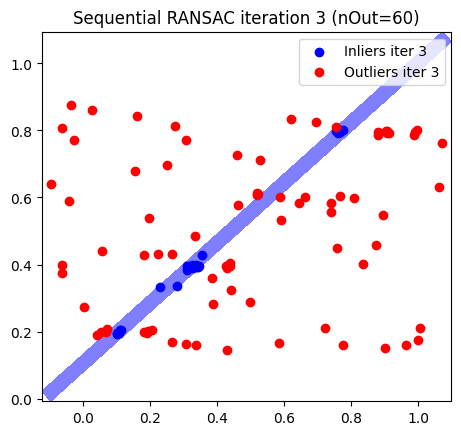

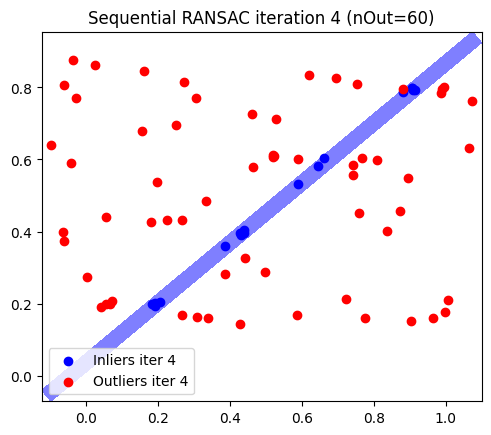

In [39]:
mat_files = [f"{rootfolder}/data/star5.mat",
             f"{rootfolder}/data/stair4.mat"]

outlier_counts = [10, 40, 50, 60]

for mat_file in mat_files:
    for nOut in outlier_counts:
        sequential_ransac_experiment(mat_file, nOut, epsi=0.02, kappa=5, E_min=10)


 MultiModel fitting on circle
----------------------------
Implement Ransac (thus run Sequential Ransac) to fit circles

In [32]:
epsi = 0.02 # inlier threshold for ransac

temp = loadmat(f'{rootfolder}/data/circle5.mat')
#temp = loadmat(f'{rootfolder}/data/circle4.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 3         # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers
G_w_outliers = np.vstack([G, np.zeros((nOut, 1))])

/tmp/ipython-input-2832099321.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
/tmp/ipython-input-2832099321.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


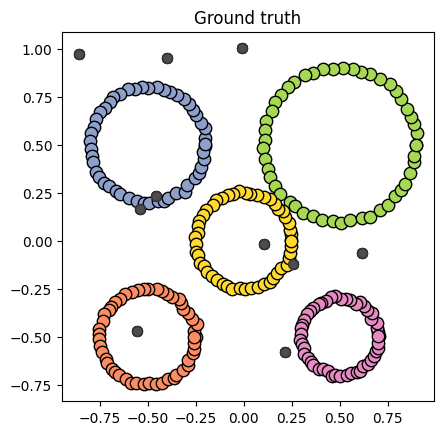

In [33]:
plt.figure(1)
display_clust(X,G_w_outliers, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

## Linear Regrssion for Circle Fitting



**AIM**

Implement RANSAC for fitting circles to a set of 2D points. We are going to incorporate Linear Regression to estimate the circle's parameters in a simplified way by reformulating the circle equation.


**CIRLCE EQUATION AND REFORMULATION**

The standard of a cirlce is:
$$
(x-a)^2 + (y-b)^2 = r^2
$$
where:

  *  $a$, $b$: coordinates of the circle's center
  *  $r$: radius of the circle

Let's reformulate the circle equation by expading and rearranging:


$$ x^2 + y^2 -2ax -2by + (a^2 + b^2 -r^2) = 0$$

and let:


$$ D = -2a, E = -2b, F = a^2 + b^2 -r^2$$

We can now write the equation of the circle equation in the following way:


$$ x^2 + y^2 + Dx + Ey + F = 0$$

The above equation is linear in terms of $D$, $E$, and $F$, suitable for the methods that we have previously used.

**REGRESSION FOR CIRCLE FITTING**

The prevously found equation can be written for each point as:


$$ x_i^2 + y_i^2 + Dx_i + Ey_i + F = 0$$

Using Linear Regression, we can solve for $D$, $E$, and $F$. Once we have obtained them we can compute the center and the radius as:


  *   Center: $$a = -D/2, b = -E/2$$
  *   Radius: $$r = \sqrt{a^2 + b^2 - F}$$

**RESIDUALS**

To compute the residuals for each point $(x_i, y_i)$, we need to measure how far the point is from the circle, considerign the circle's center and its radius.

The residual for a point $(x_i, y_i)$ is the difference between the actual distance from the point to the circle's center $(a, b)$ and the readius of the circle $r$.

We are going to perform the following step:


1.   Compute the distance from the point to the circle's center:
      $$ Distance\ to\ center = \sqrt{(x_i - a)^2 + (x_i - b)^2}$$
2.   Compute the residual:
      $$ Residual = |\sqrt{(x_i - a)^2 + (x_i - b)^2} - r|$$

In this way, we are measuring how far the point is from the circle, considering both the center and the radius.












In [ ]:
def display_circle(model, color='b', linestyle='-', label= None):
  # Extract the circle parameters
  a, b, r = model
  t = np.linspace(0, 2*np.pi, 100)
  x = a + r * np.cos(t)
  y = b + r * np.sin(t)
  plt.plot(x, y, color=color, linestyle=linestyle, label=label)

In [ ]:
def res_circle(points, theta):
  # Extract the circle parameters
    x0, y0, r = theta
    X = points[0, :]
    Y = points[1, :]
    distance = np.sqrt((X - x0)**2 + (Y - y0)**2)
    res = np.abs(distance - r)
    return res

In [ ]:
def fit_circle_ols(P):
  # Extract x and y coordinates
  X = P[0, :]
  Y = P[1, :]
  # Design matrix
  A = np.vstack([X, Y, np.ones_like(X)]).T
  # Response vector
  B = X**2 + Y**2
  # Solve for theta using OLS
  C, _, _, _ = np.linalg.lstsq(A, B, rcond=None)
  # Extract coefficients
  a = C[0]/2
  b = C[1]/2
  c = C[2]
  r = np.sqrt(a**2 + b**2 + c)
  theta = [a, b, r]

  return theta

In [ ]:
def simpleRANSAC_circle(X, eps, cardmss = 2):
  """
  SIMPLERANSAC - Robust fit with the LMEDS algorithm
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1]
  # Desired probability of success
  alpha = 0.99

  # Pessimistic estimate of inliers fraction
  f = 0.5

  # set maximum number of iterations
  MaxIterations =  int(np.ceil(np.log(1-alpha)/np.log(1 - (1 - f)**cardmss)))

  # set maximum consensus reached
  maxscore = - np.inf

  # initialize bestinliers set
  bestinliers = []

  # initialize bestmodel
  bestmodel = []

  for i in range(MaxIterations):

    # Generate cardmss random indices in the range 0..n-1
    mss = np.random.choice(n, cardmss, replace=False)

    # Fit a circle to the minal sample set
    theta = fit_circle_ols(X[:, mss])

    # Evaluate distances between points and model
    sqres = res_circle(X, theta)

    # identify inliers: consensus set
    inliers = np.where(sqres < eps)[0]

    # assess consensus (the number of inliers)
    score = len(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta

  return bestmodel, bestinliers

In [ ]:
Y = X.copy()  # Take a copy of X to be modified

# Containers for the fitted models and inliers
currentModel = []
currentInliers = []

E_min = 10
cnt = 0

while cnt < kappa:
    # Fit a circle using RANSAC
    current_best_model, current_best_inliers = simpleRANSAC_circle(Y, epsi,cardmss)
     # Stopping criteria: if the last model has too few inliers, stop
    if len(current_best_inliers) < E_min:
        break
    current_best_model = fit_circle_ols(Y[:, current_best_inliers])
    # Save the current model and its inliers
    currentModel.append(current_best_model)
    currentInliers.append(current_best_inliers)

    # Remove the inliers of the current model from the dataset
    Y = np.delete(Y, current_best_inliers, axis=1)

    # Update the iteration counter
    cnt += 1

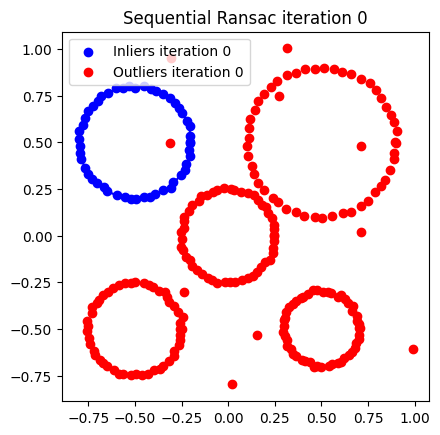

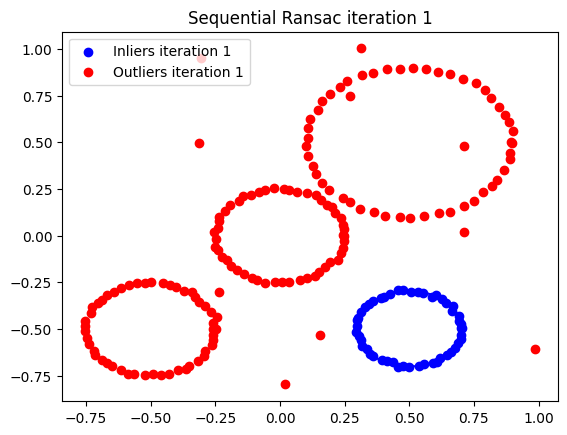

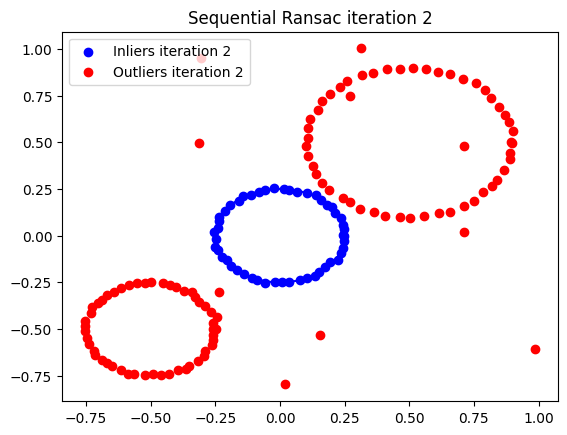

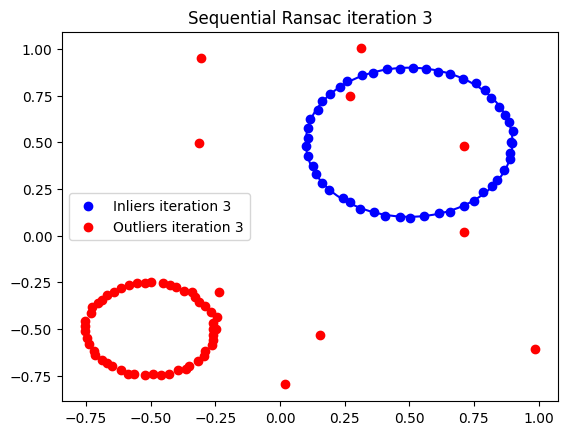

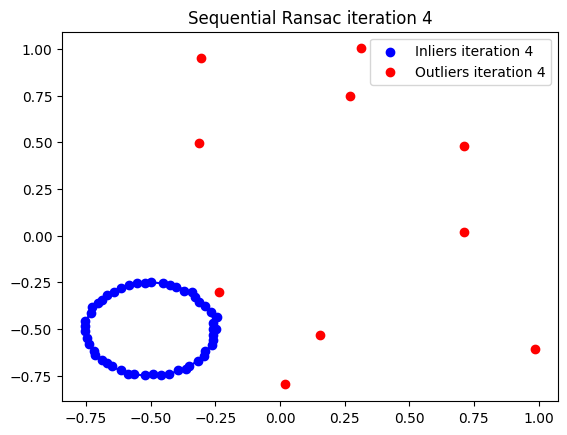

In [ ]:
Y = X.copy()
plt.gca().set_aspect('equal')

# Iterative over the models found by RANSAC
for i in range(kappa):
  # Display circular band for the current model
  display_circle(currentModel[i], col)

  # Plot inliers for the current circle
  plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], color='blue', marker='o', label=f'Inliers iteration {i}')

  # Plot outliers for the current circle
  outliers = np.setdiff1d(np.arange(Y.shape[1]), currentInliers[i])
  plt.scatter(Y[0, outliers], Y[1, outliers], color='red', marker='o', label=f'Outliers iteration {i}')

  # Remove inliers from the dataset for the next iteration
  Y = np.delete(Y, currentInliers[i], axis=1)

  # Update the plot title and legend
  plt.title(f'Sequential Ransac iteration {i:d}')
  plt.legend()
  plt.show()
